# Spam Classifier

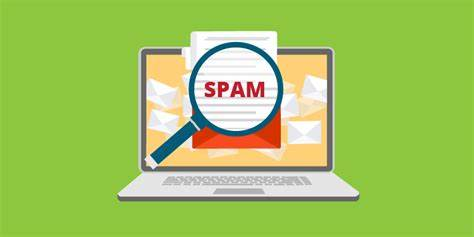
**Problem statement**
* The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages. tagged according being ham (legitimate) or spam.
* The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text  
1. Perform exploratory data analysis to discover properties of ham/spam mail.
2. Build a model that predicts whether a message is ham/spam.

## Step #0: Preparation
### Libraries import

In [1]:
# libraries for analysis dataset
import pandas as pd
import numpy as np
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# libraries for NLP
import string
import nltk
from nltk.corpus import stopwords
stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
# libraries for preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# libraries for model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
# libraries for balance dataset
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline
# libraries for scoring
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             recall_score,
                             roc_auc_score,
                             accuracy_score, 
                             precision_score, 
                             f1_score,
                             ConfusionMatrixDisplay
                            )
from imblearn.metrics import classification_report_imbalanced

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Functions

In [2]:
# defining a function to clean up the text
def message_cleaning(message):
    test_punc_removed = [char for char in message if char not in string.punctuation]
    
    test_punc_removed_join = ''.join(test_punc_removed)
    test_punc_removed_join_clean = [word for word in test_punc_removed_join.split() if word.lower() not in stopwords.words('english')]
    return test_punc_removed_join_clean

In [3]:
# lemmatization (removing the suffixes of similar words to their root word to get uniformity)
def lemmatizeSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)    

def lemmatize (df):
    new_df = df
    new_df = new_df.drop('text', axis=1)
    text_list = []
    for j in range(0, len(df)):
        lemmatized = lemmatizeSentence(df.iloc[j]['text'])
        text_list.append(lemmatized)
        df.replace(df.iloc[j]['text'],lemmatized)
    new_df.loc[:, "text"] = text_list
    return new_df

In [4]:
results = pd.DataFrame(columns=['modelName', 'accuracy_test', 'rocauc_test','precision_test', 'recall_test', 'f1_test'])
# define function to show the results
def show_results(df):
    r = df.sort_values(by =['accuracy_test', 'rocauc_test', 'precision_test','recall_test','f1_test'], ascending = False)
    return r

In [5]:
# define function to show the results for classifier
def score_show(name, _classifier, X_train, X_test, y_train, y_test):

    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 3)) 
    
    print('Train: ')
    y_pred_train = _classifier.predict(X_train)
  
    print('accuracy %s' % accuracy_score(y_train, y_pred_train))
    axes[0].set_title('Train Confusion Matrix')
    cm = confusion_matrix(y_train, y_pred_train)
    sns.heatmap(cm, annot = True, fmt = 'd', ax = axes[0], cmap=plt.cm.viridis)
    
    print(classification_report_imbalanced(y_train, y_pred_train))
    print('----------------------------------------------')
    print('Test: ')
    y_pred_test = _classifier.predict(X_test)
    
    print('accuracy %s' % accuracy_score(y_test, y_pred_test))
    axes[1].set_title('Test Confusion Matrix')
    cm_t = confusion_matrix(y_test, y_pred_test)
    sns.heatmap(cm_t, annot = True, fmt = 'd', ax = axes[1], cmap=plt.cm.viridis)
    
    print(classification_report_imbalanced(y_test, y_pred_test))

    results.loc[len(results.index)] = [name, 
                                       accuracy_score(y_test,y_pred_test), 
                                       #accuracy_score(y_train, y_pred_train), 
                                       roc_auc_score(y_test, y_pred_test), 
                                      # roc_auc_score(y_train, y_pred_train),
                                       precision_score(y_test, y_pred_test),
                                       #precision_score(y_train, y_pred_train),
                                       recall_score(y_test, y_pred_test),
                                       #recall_score(y_train, y_pred_train),
                                       f1_score(y_test, y_pred_test)]
                                       #f1_score(y_train, y_pred_train)]
                                      

In [6]:
# create function of plot wordcloud
def wordcloud_plot(text, title):
    cleaned_df = message_cleaning(text)
    wc = WordCloud(
        background_color = "white", 
        max_words = 2000, 
        max_font_size = 40,
        scale = 3,
        stopwords = STOPWORDS
    ).generate(" ".join(cleaned_df))
    plt.figure(figsize=(15,6))
    plt.imshow(wc, interpolation = "bilinear",cmap='magma')
    plt.axis('off')
    plt.title(title)
    plt.show()

## Step #1 : Import dataset

In [7]:
# load the dataset
spam_df = pd.read_csv('../emails.csv')
spam_df.shape

(5728, 2)

In [8]:
# show the first 5 rows of the dataset
spam_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [9]:
# show the last 5 rows of the dataset
spam_df.tail()

,text,spam
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0
5727,Subject: news : aurora 5 . 2 update aurora ve...,0


In [10]:
# information of the dataset
spam_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [11]:
# description of dataset
spam_df.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Step #2 : Visualize dataset

In [12]:
# create datasets on spam and ham
ham = spam_df[spam_df['spam']==0]
spam = spam_df[spam_df['spam']==1]

In [13]:
# let's take a look at ham
ham

,text,spam
1368,"Subject: hello guys , i ' m "" bugging you "" f...",0
1369,Subject: sacramento weather station fyi - - ...,0
1370,Subject: from the enron india newsdesk - jan 1...,0
1371,Subject: re : powerisk 2001 - your invitation ...,0
1372,Subject: re : resco database and customer capt...,0
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


In [14]:
# let's take a look at spam
spam

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
1363,Subject: are you ready to get it ? hello ! v...,1
1364,Subject: would you like a $ 250 gas card ? do...,1
1365,"Subject: immediate reply needed dear sir , i...",1
1366,Subject: wanna see me get fisted ? fist bang...,1


In [15]:
# total No of Spam and Not Spam Category
spam_df['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

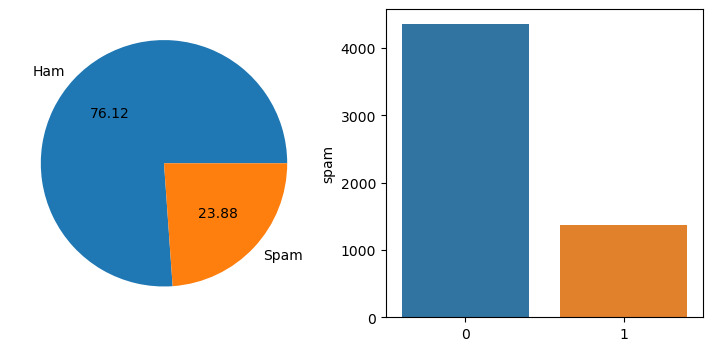

In [16]:
# describes the count of the class labels
plt.figure (figsize=(9,4))
plt.subplot(1,2,1)
plt.pie(spam_df['spam'].value_counts(), labels=['Ham','Spam'], autopct='%0.2f')
plt.subplot(1,2,2)
sns.barplot(x=spam_df['spam'].value_counts().index, y=spam_df['spam'].value_counts(),data=spam_df)
plt.show()

 Distribution is imbalanced.

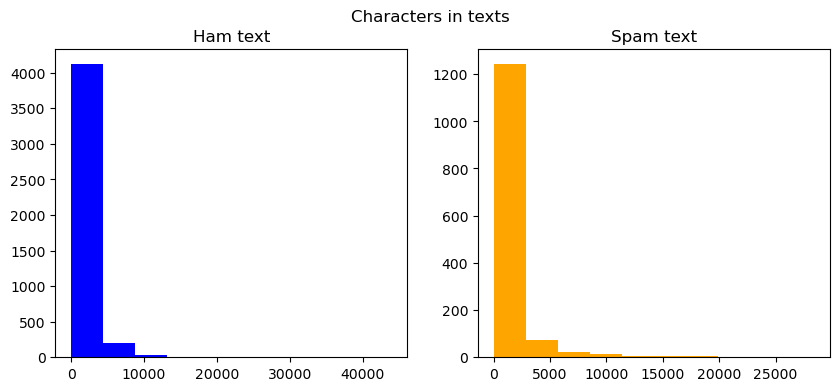

In [17]:
# No of Words in Spam and Ham Text
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
text_len=spam_df[spam_df['spam']==0]['text'].str.len()
ax1.hist(text_len,color='blue')
ax1.set_title('Ham text')
text_len=spam_df[spam_df['spam']==1]['text'].str.len()
ax2.hist(text_len,color='orange')
ax2.set_title('Spam text')
fig.suptitle('Characters in texts')
plt.show()

From the two histograms above we can conclude that spam texts are mostly 20,000 symbols in length and ham texts are of shorter length.

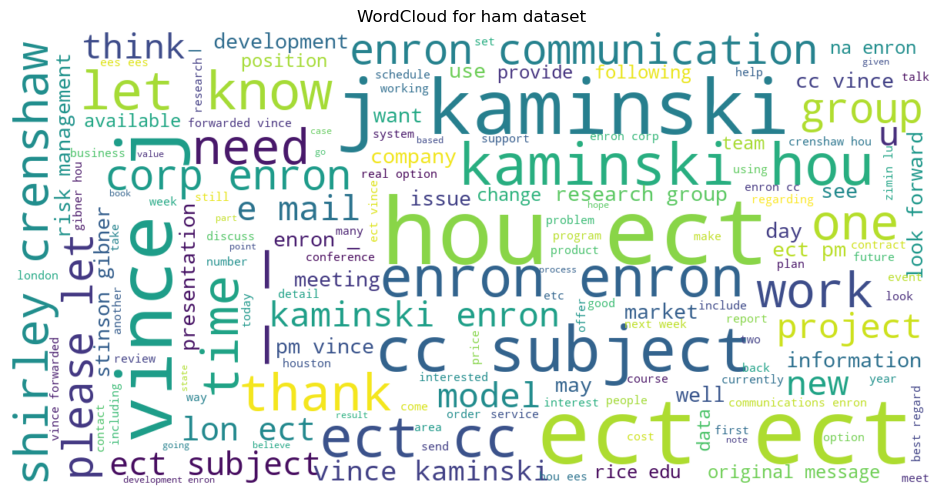

In [18]:
# let's see the plot of wordcloud of dataset with spam and ham text
wordcloud_plot(ham['text'], 'WordCloud for ham dataset')

etc, j, kaminski, hou, vince, enron, thank, etc. are some of the most common words in ham text.

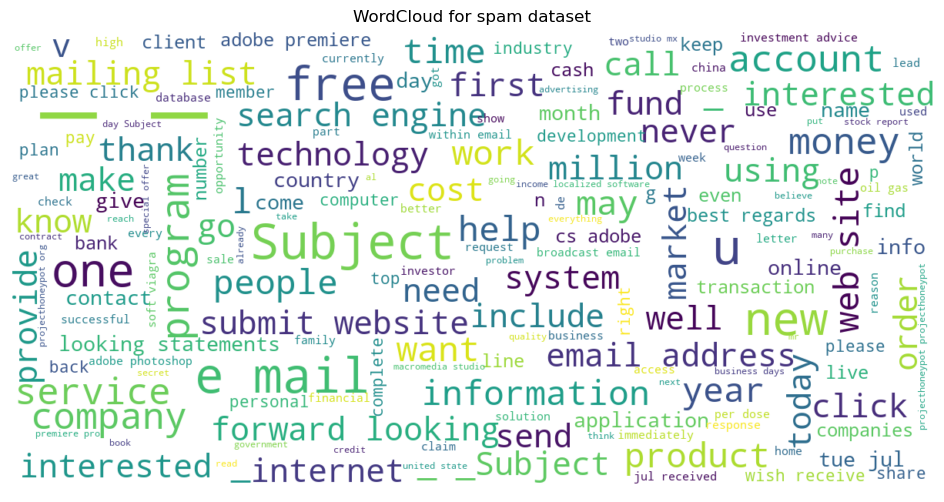

In [19]:
wordcloud_plot(spam['text'], 'WordCloud for spam dataset')

I, Subject, program, work, million, web site, free, money, etc. are some of the most common words in spam text.

## Step #3: Filter dataset
Lemmatization converts a word to its root form, removing the prefix or suffix of a word.

In [20]:
# create a dataset using WordNetLemmatizer
spam_df_lem = lemmatize(spam_df)

## Step #4: Create testing and training dataset/ data cleaning
### Let's apply count vectorizer to our spam/ ham 
In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix(Vectorizer).

In [21]:
vectorizer = CountVectorizer(analyzer=message_cleaning)
spamham_vectorizer = vectorizer.fit_transform(spam_df_lem['text'])
spamham_vectorizer.shape

(5728, 34571)

In [22]:
print(vectorizer.get_feature_names())

['\x01', '\x02', '\x03', '\x05', '\x06', '\x07', '\x08', '\x0f', '\x10', '\x12', '\x14', '\x15', '\x19', '0', '00', '000', '0000', '000000', '00000000', '0000000000', '000000000003619', '000000000003991', '000000000003997', '000000000005168', '000000000005409', '000000000005411', '000000000005412', '000000000005413', '000000000005820', '000000000006238', '000000000006452', '000000000007494', '000000000007498', '000000000007876', '000000000010552', '000000000011185', '000000000012677', '000000000012734', '000000000012735', '000000000012736', '000000000012738', '000000000012741', '000000000012987', '000000000013085', '000000000013287', '000000000015384', '000000000015793', '000000000023619', '000000000024099', '000000000025307', '000000000025312', '000010220', '0000102317', '0000102374', '0000102789', '0000104281', '0000104282', '0000104486', '0000104631', '0000104730', '0000104776', '0000104778', '0000107043', '0000108729', '000066', '0001', '000166', '0002', '000202', '0003', '0004', '

## Step #5: Divide the data into training and testing prior ro training

In [23]:
# setting values for labels and feature as y and X
X = spamham_vectorizer
label = spam_df['spam'].values
y = label
X.shape, y.shape

((5728, 34571), (5728,))

In [24]:
# splitting data on train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape

((4582, 34571), (1146, 34571))

## Step#6: Train Dataset and Check Results
### Step#6.1: MultinomialNB

In [25]:
# training the model using Naive Bayes classifier with Grid Search
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

params_NB= {'alpha': [1, 2]}

NB_gridSearch_classifier = GridSearchCV(NB_classifier, params_NB, cv = 6, n_jobs = -1, scoring = 'accuracy')
NB_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [1, 2]}, scoring='accuracy')

In [26]:
# selection of the best parameters
NB_gridSearch_classifier.best_params_

{'alpha': 2}

Train: 
accuracy 0.9958533391532082
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.99      1.00      1.00      0.99      3472
          1       0.99      0.99      1.00      0.99      1.00      0.99      1110

avg / total       1.00      1.00      0.99      1.00      1.00      0.99      4582

----------------------------------------------
Test: 
accuracy 0.9904013961605584
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.99      0.99      0.99      0.98       888
          1       0.97      0.99      0.99      0.98      0.99      0.98       258

avg / total       0.99      0.99      0.99      0.99      0.99      0.98      1146



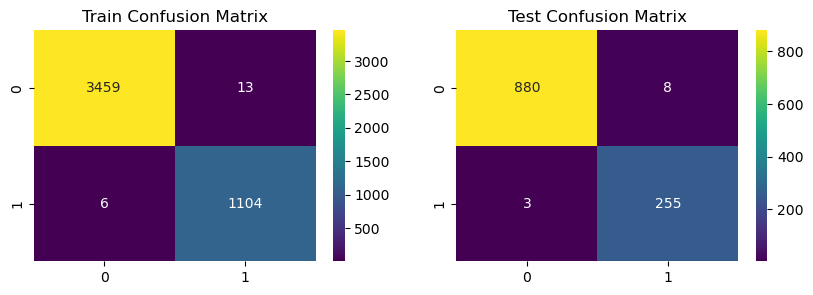

In [27]:
# let's have a look at the classification report and confution matrix
score_show('MultinominalNB with Vectorizer',NB_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 880 times and spam 255 times. However, the model made a false positive error 8 times and a false negative error 3 times.

#### Combination of over- and under-sampling methode to Balance Dataset

In [28]:
# training the model using Pipeline with Grid Search
NB_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('NB_clf', MultinomialNB())
                    ])
NB_pipe.fit(X_train, y_train)

params_NB= {'NB_clf__alpha': [1, 0]}

NB_gridSearch_sam_classifier = GridSearchCV(NB_pipe, params_NB, cv = 6, n_jobs = -1, scoring = 'accuracy')
NB_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('NB_clf', MultinomialNB())]),
             n_jobs=-1, param_grid={'NB_clf__alpha': [1, 0]},
             scoring='accuracy')

In [29]:
# selection of the best parameters
NB_gridSearch_sam_classifier.best_params_

{'NB_clf__alpha': 1}

Train: 
accuracy 0.9965080750763858
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      0.99      3472
          1       0.99      1.00      1.00      0.99      1.00      0.99      1110

avg / total       1.00      1.00      1.00      1.00      1.00      0.99      4582

----------------------------------------------
Test: 
accuracy 0.9895287958115183
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      0.99      0.99      0.99      0.98       888
          1       0.96      0.99      0.99      0.98      0.99      0.98       258

avg / total       0.99      0.99      0.99      0.99      0.99      0.98      1146



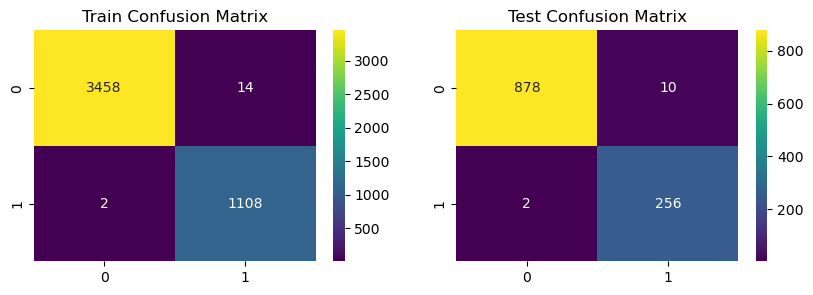

In [30]:
# let's have a look at the classification report and confution matrix
score_show('MultinominalNB with Vectorizer and Balance',NB_gridSearch_sam_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 878 times and spam 256 times. However, the model made a false positive error 10 times and a false negative error 2 times.

### Step#6.2: Logistic Regression

In [31]:
# training the model using Logistic Regression with Grid Search
LR_classifier = LogisticRegression(class_weight= 'balanced')
LR_classifier.fit(X_train, y_train)

params_LR= {'solver': ['lbfgs', 'liblinear','saga'], 
             'random_state': [0], 
             'penalty': ['l1', 'l2', 'none'],
             'C': [0.3,0.4,0.5], 
             'dual':['bool', False]
             }

LR_gridSearch_classifier = GridSearchCV(LR_classifier, params_LR, cv = 6, n_jobs = -1, scoring = 'accuracy')
LR_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=LogisticRegression(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'C': [0.3, 0.4, 0.5], 'dual': ['bool', False],
                         'penalty': ['l1', 'l2', 'none'], 'random_state': [0],
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [32]:
# selection of the best parameters
LR_gridSearch_classifier.best_params_

{'C': 0.5,
 'dual': False,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'liblinear'}

Train: 
accuracy 0.9997817546922741
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      3472
          1       1.00      1.00      1.00      1.00      1.00      1.00      1110

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      4582

----------------------------------------------
Test: 
accuracy 0.9825479930191972
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.99      0.99      0.98      0.97       888
          1       0.94      0.99      0.98      0.96      0.98      0.97       258

avg / total       0.98      0.98      0.99      0.98      0.98      0.97      1146



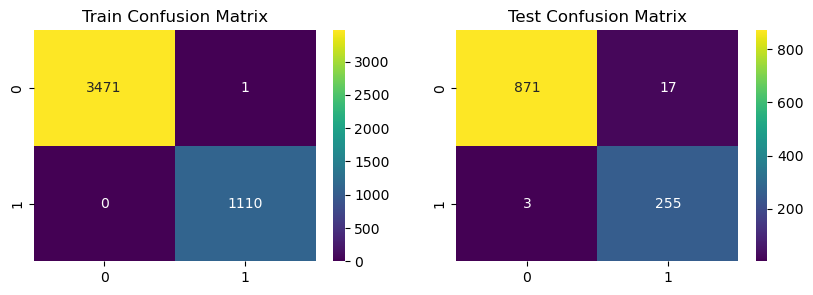

In [33]:
# let's have a look at the classification report and confution matrix
score_show('Logistic Regression with Vectorizer',LR_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 871 times and spam 255 times. However, the model made a false positive error 17 times and a false negative error 3 times.

#### Combination of over- and under-sampling methode to Balance Dataset

In [34]:
# training the model using Pipeline with Grid Search
LR_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('LR_clf', LogisticRegression())
                    ])
params_LR= {'LR_clf__solver': ['lbfgs', 'liblinear','saga'], 
            'LR_clf__random_state': [0], 
            'LR_clf__penalty': ['l1', 'l2', 'none'], 
            'LR_clf__C': [0.3,0.4,0.5],
            'LR_clf__dual':['bool', False], 
            'LR_clf__class_weight': ['balanced']
            }
LR_gridSearch_sam_classifier = GridSearchCV(LR_pipe, params_LR, cv = 6, n_jobs = -1, scoring = 'accuracy')
LR_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('LR_clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'LR_clf__C': [0.3, 0.4, 0.5],
                         'LR_clf__class_weight': ['balanced'],
                         'LR_clf__dual': ['bool', False],
                         'LR_clf__penalty': ['l1', 'l2', 'none'],
                         'LR_clf__random_state': [0],
                         'LR_clf__solver': ['lbfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [35]:
# selection of the best parameters
LR_gridSearch_sam_classifier.best_params_

{'LR_clf__C': 0.5,
 'LR_clf__class_weight': 'balanced',
 'LR_clf__dual': False,
 'LR_clf__penalty': 'none',
 'LR_clf__random_state': 0,
 'LR_clf__solver': 'lbfgs'}

Train: 
accuracy 1.0
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      3472
          1       1.00      1.00      1.00      1.00      1.00      1.00      1110

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      4582

----------------------------------------------
Test: 
accuracy 0.9851657940663177
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.98      0.99      0.98      0.97       888
          1       0.95      0.98      0.99      0.97      0.98      0.97       258

avg / total       0.99      0.99      0.98      0.99      0.98      0.97      1146



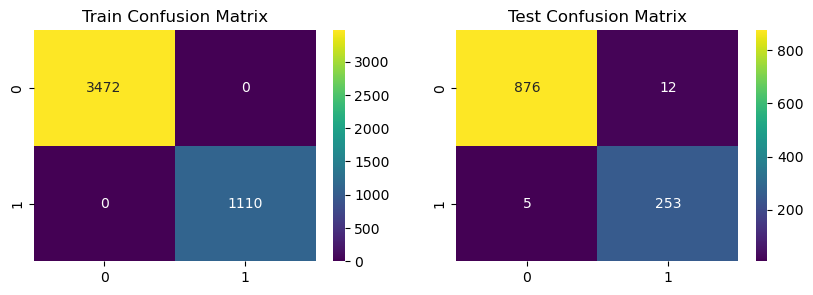

In [36]:
# let's have a look at the classification report and confution matrix
score_show('Logistic Regression with Vectorizer and Balanced',LR_gridSearch_sam_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 876 times and spam 253 times. However, the model made a false positive error 12 times and a false negative error 5 times.

### Step#6.3: Random Forest Classifier

In [37]:
# training the model using Random Forest Classifier with Grid Search
RF_classifier = RandomForestClassifier(class_weight='balanced')
RF_classifier.fit(X_train,y_train)

params_RF= {'n_estimators': [20,50,100],
             'criterion': ['gini','entropy','log_loss'],
             'max_depth': [5,8,10],
             'max_features': ['sqrt', 'log2', None],
             'n_jobs': [-1]
            }

RF_gridSearch_classifier = GridSearchCV(RF_classifier, params_RF, cv = 6, n_jobs = -1, scoring = 'accuracy')
RF_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 8, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [20, 50, 100], 'n_jobs': [-1]},
             scoring='accuracy')

In [38]:
# selection of the best parameters
RF_gridSearch_classifier.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': None,
 'n_estimators': 20,
 'n_jobs': -1}

Train: 
accuracy 0.9574421649934527
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      1.00      0.97      0.97      0.94      3472
          1       0.85      1.00      0.94      0.92      0.97      0.95      1110

avg / total       0.96      0.96      0.99      0.96      0.97      0.94      4582

----------------------------------------------
Test: 
accuracy 0.9336823734729494
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.93      0.96      0.96      0.94      0.88       888
          1       0.79      0.96      0.93      0.87      0.94      0.89       258

avg / total       0.94      0.93      0.95      0.94      0.94      0.89      1146



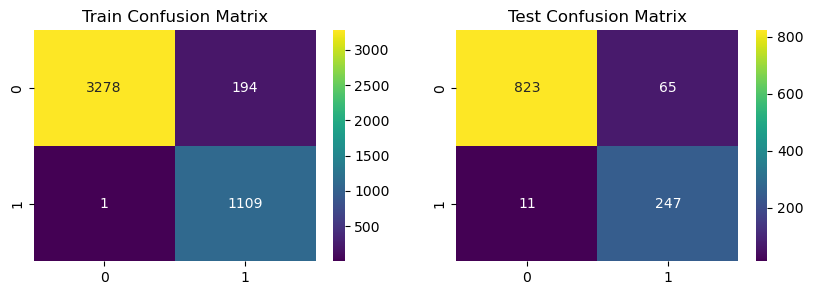

In [39]:
# let's have a look at the classification report and confution matrix
score_show('Random Forest with Vectorizer',RF_gridSearch_classifier,X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 823 times and spam 247 times. However, the model made a false positive error 65 times and a false negative error 11 times.

#### Combination of over- and under-sampling methode to Balance Dataset

In [40]:
# training the model using Pipeline with Grid Search
RF_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('RF_clf', RandomForestClassifier())
                    ])
params_RF= {'RF_clf__n_estimators': [20,50,100],
            'RF_clf__criterion': ['gini','entropy','log_loss'],
            'RF_clf__max_depth': [5,8,10],
            'RF_clf__max_features': ['sqrt', 'log2', None],
            'RF_clf__n_jobs': [-1],
            'RF_clf__class_weight':['balanced']
            }
RF_gridSearch_sam_classifier = GridSearchCV(RF_pipe, params_RF, cv = 6, n_jobs = -1, scoring = 'accuracy')
RF_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('RF_clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RF_clf__class_weight': ['balanced'],
                         'RF_clf__criterion': ['gini', 'entropy', 'log_loss'],
                         'RF_clf__max_depth': [5, 8, 10],
                         'RF_clf__max_features': ['sqrt', 'log2', None],
                         'RF_clf__n_estimators': [20, 50, 100],
                         'RF_clf__n_jobs': [-1]},
             scoring='accuracy')

In [41]:
# selection of the best parameters
RF_gridSearch_sam_classifier.best_params_

{'RF_clf__class_weight': 'balanced',
 'RF_clf__criterion': 'log_loss',
 'RF_clf__max_depth': 10,
 'RF_clf__max_features': None,
 'RF_clf__n_estimators': 100,
 'RF_clf__n_jobs': -1}

Train: 
accuracy 0.9598428633784374
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.95      1.00      0.97      0.97      0.94      3472
          1       0.86      1.00      0.95      0.92      0.97      0.95      1110

avg / total       0.97      0.96      0.99      0.96      0.97      0.94      4582

----------------------------------------------
Test: 
accuracy 0.9380453752181501
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.93      0.96      0.96      0.94      0.89       888
          1       0.80      0.96      0.93      0.87      0.94      0.89       258

avg / total       0.95      0.94      0.95      0.94      0.94      0.89      1146



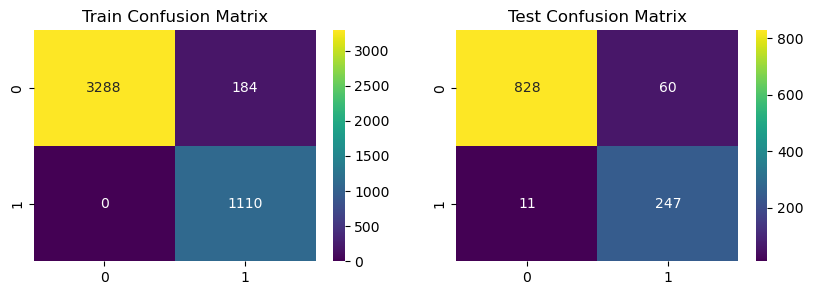

In [42]:
# let's have a look at the classification report and confution matrix
score_show('Random Forest with Vectorizer and Balanced',RF_gridSearch_sam_classifier,X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 828 times and spam 247 times. However, the model made a false positive error 60 times and a false negative error 11 times.

### Step#6.4: K-Nearest Neighbor Classifier

In [43]:
# training the model using K-Nearest Neighbor Classifier with Grid Search
KN_classifier = KNeighborsClassifier()
KN_classifier.fit(X_train, y_train)

params_KN = {'n_neighbors': [1,2,3],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'euclidean', 'manhattan'],
              'p':[1,2,3]
             }
                   
KN_gridSearch_classifier = GridSearchCV(KN_classifier, params_KN, cv = 6, n_jobs = -1, scoring ='accuracy')
KN_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [44]:
# selection of the best parameters
KN_gridSearch_classifier.best_params_

{'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}

Train: 
accuracy 1.0
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      3472
          1       1.00      1.00      1.00      1.00      1.00      1.00      1110

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      4582

----------------------------------------------
Test: 
accuracy 0.9179755671902269
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.98      0.71      0.95      0.83      0.72       888
          1       0.90      0.71      0.98      0.80      0.83      0.68       258

avg / total       0.92      0.92      0.77      0.91      0.83      0.71      1146



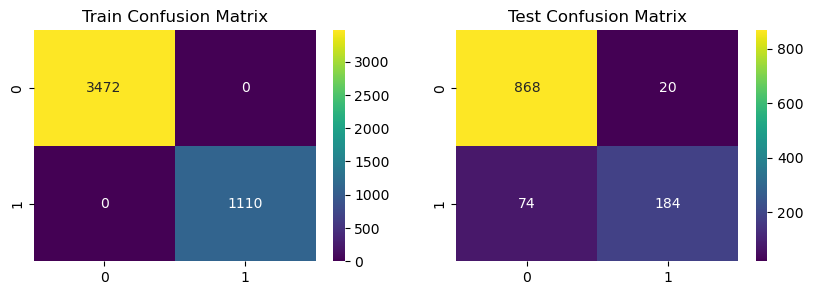

In [45]:
# let's have a look at the classification report and confution matrix
score_show('KNN with Vectorizer',KN_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 868 times and spam 184 times. However, the model made a false positive error 20 times and a false negative error 74 times.

 #### Combination of over- and under-sampling methode to Balance Dataset

In [46]:
# training the model using Pipeline with Grid Search
KN_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('KN_clf', KNeighborsClassifier())
                    ])

params_KN = {'KN_clf__n_neighbors': [1,2,3],
             'KN_clf__weights': ['uniform', 'distance'],
             'KN_clf__metric': ['minkowski', 'euclidean', 'manhattan'],
             'KN_clf__p':[1,2,3]
             }
                   
KN_gridSearch_sam_classifier = GridSearchCV(KN_pipe, params_KN, cv = 6, n_jobs = -1, scoring ='accuracy')
KN_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('KN_clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'KN_clf__metric': ['minkowski', 'euclidean',
                                            'manhattan'],
                         'KN_clf__n_neighbors': [1, 2, 3],
                         'KN_clf__p': [1, 2, 3],
                         'KN_clf__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [47]:
# selection of the best parameters
KN_gridSearch_sam_classifier.best_params_

{'KN_clf__metric': 'minkowski',
 'KN_clf__n_neighbors': 2,
 'KN_clf__p': 2,
 'KN_clf__weights': 'uniform'}

Train: 
accuracy 1.0
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      3472
          1       1.00      1.00      1.00      1.00      1.00      1.00      1110

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      4582

----------------------------------------------
Test: 
accuracy 0.9179755671902269
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.98      0.71      0.95      0.83      0.72       888
          1       0.90      0.71      0.98      0.80      0.83      0.68       258

avg / total       0.92      0.92      0.77      0.91      0.83      0.71      1146



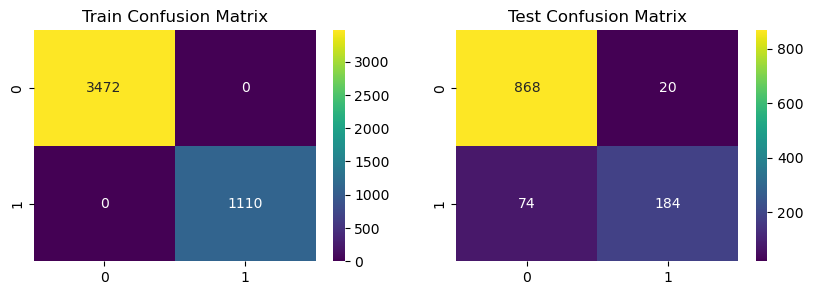

In [48]:
# let's have a look at the classification report and confution matrix
score_show('KNN with Vectorizer and Balance',KN_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 868 times and spam 184 times. However, the model made a false positive error 20 times and a false negative error 74 times.

### Step#6.5: Decision Tree Classifier

In [49]:
# training the model using  Decision Tree Classifier with Grid Search
DT_classifier = DecisionTreeClassifier(class_weight='balanced')
DT_classifier.fit(X_train, y_train)

params_DT = {'criterion': ['gini', 'entropy'],
             'max_depth': [None, 2, 4, 6, 8, 10],
             'min_samples_leaf': [13,15,17,19],
             'class_weight': ['balanced'],
             'splitter': ['best', 'random']
             }
                   
DT_gridSearch_classifier = GridSearchCV(DT_classifier, params_DT, cv = 3,n_jobs = -1, scoring ='accuracy')
DT_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 4, 6, 8, 10],
                         'min_samples_leaf': [13, 15, 17, 19],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [50]:
# selection of the best parameters
DT_gridSearch_classifier.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 13,
 'splitter': 'best'}

Train: 
accuracy 0.956787429070275
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.95      0.98      0.97      0.97      0.93      3472
          1       0.86      0.98      0.95      0.92      0.97      0.93      1110

avg / total       0.96      0.96      0.97      0.96      0.97      0.93      4582

----------------------------------------------
Test: 
accuracy 0.9493891797556719
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.95      0.95      0.97      0.95      0.90       888
          1       0.84      0.95      0.95      0.89      0.95      0.90       258

avg / total       0.95      0.95      0.95      0.95      0.95      0.90      1146



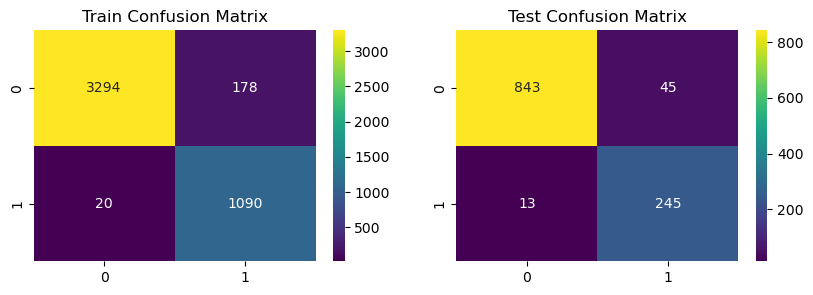

In [51]:
# let's have a look at the classification report and confution matrix
score_show('DecisionTreeClassifier with Vectorizer',DT_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 843 times and spam 245 times. However, the model made a false positive error 45 times and a false negative error 13 times.

 #### Combination of over- and under-sampling methode to Balance Dataset

In [52]:
# training the model using Pipeline with Grid Search
DT_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('DT_clf', DecisionTreeClassifier())
                    ])
params_DT = {'DT_clf__criterion': ['gini', 'entropy'],
             'DT_clf__max_depth': [None, 2, 4, 6, 8, 10],
             'DT_clf__min_samples_leaf': [13,15,17,19],
             'DT_clf__class_weight': ['balanced'],
             'DT_clf__splitter': ['best', 'random']
             }              
DT_gridSearch_sam_classifier = GridSearchCV(DT_pipe, params_DT, cv = 5, n_jobs = -1, scoring ='accuracy')
DT_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('DT_clf', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'DT_clf__class_weight': ['balanced'],
                         'DT_clf__criterion': ['gini', 'entropy'],
                         'DT_clf__max_depth': [None, 2, 4, 6, 8, 10],
                         'DT_clf__min_samples_leaf': [13, 15, 17, 19],
                         'DT_clf__splitter': ['best', 'random']},
             scoring='accuracy')

In [53]:
# selection of the best parameters
DT_gridSearch_sam_classifier.best_params_

{'DT_clf__class_weight': 'balanced',
 'DT_clf__criterion': 'gini',
 'DT_clf__max_depth': 10,
 'DT_clf__min_samples_leaf': 15,
 'DT_clf__splitter': 'best'}

Train: 
accuracy 0.9476211261457879
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.94      0.98      0.96      0.96      0.91      3472
          1       0.83      0.98      0.94      0.90      0.96      0.92      1110

avg / total       0.95      0.95      0.97      0.95      0.96      0.92      4582

----------------------------------------------
Test: 
accuracy 0.931064572425829
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.93      0.95      0.95      0.94      0.87       888
          1       0.79      0.95      0.93      0.86      0.94      0.88       258

avg / total       0.94      0.93      0.94      0.93      0.94      0.88      1146



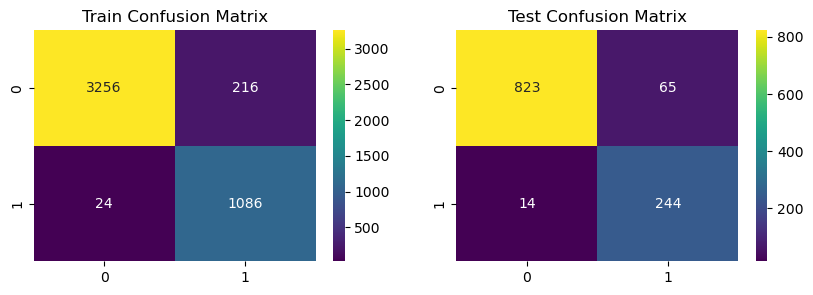

In [54]:
# let's have a look at the classification report and confution matrix
score_show('DecisionTreeClassifier with Vectorizer and Balance',DT_gridSearch_sam_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 823 times and spam 244 times. However, the model made a false positive error 65 times and a false negative error 14 times.

### Step#6.6: Support Vector Classifier

In [55]:
# training the model using Support Vector Classifier with Grid Search
SVC_classifier = SVC(class_weight= 'balanced')
SVC_classifier.fit(X_train, y_train)

params_SVC= {'C': [1.0,3,5],
             'kernel': ['rbf', 'poly'], 
             'gamma': ['scale', 'auto'],              
             'verbose': ['bool', False] 
            }

SVC_gridSearch_classifier = GridSearchCV(SVC_classifier, params_SVC, cv = 6, n_jobs = -1, scoring = 'accuracy')
SVC_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [1.0, 3, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly'],
                         'verbose': ['bool', False]},
             scoring='accuracy')

In [56]:
# selection of the best parameters
SVC_gridSearch_classifier.best_params_

{'C': 5, 'gamma': 'scale', 'kernel': 'rbf', 'verbose': False}

Train: 
accuracy 0.9954168485377565
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.99      1.00      1.00      1.00      0.99      3472
          1       0.98      1.00      0.99      0.99      1.00      0.99      1110

avg / total       1.00      1.00      1.00      1.00      1.00      0.99      4582

----------------------------------------------
Test: 
accuracy 0.9781849912739965
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.99      0.95      0.99      0.97      0.94       888
          1       0.96      0.95      0.99      0.95      0.97      0.93       258

avg / total       0.98      0.98      0.96      0.98      0.97      0.94      1146



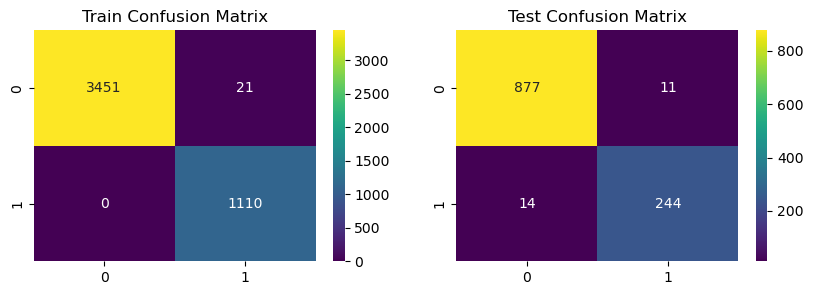

In [57]:
# let's have a look at the classification report and confution matrix
score_show('SVC with Vectorizer',SVC_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 877 times and spam 244 times. However, the model made a false positive error 11 times and a false negative error 14 times.

 #### Combination of over- and under-sampling methode to Balance Dataset

In [58]:
# training the model using Pipeline with Grid Search
SVC_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('SVC_clf', SVC())
                     ])
params_SVC= {'SVC_clf__C': [1.0,3,5], 
             'SVC_clf__kernel': ['rbf', 'poly'], 
             'SVC_clf__gamma': ['scale', 'auto'],              
             'SVC_clf__verbose': ['bool', False], 
             'SVC_clf__class_weight':['balanced']
            }
SVC_gridSearch_sam_classifier = GridSearchCV(SVC_pipe, params_SVC, cv = 6, n_jobs = -1, scoring = 'accuracy')
SVC_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('SVC_clf', SVC())]),
             n_jobs=-1,
             param_grid={'SVC_clf__C': [1.0, 3, 5],
                         'SVC_clf__class_weight': ['balanced'],
                         'SVC_clf__gamma': ['scale', 'auto'],
                         'SVC_clf__kernel': ['rbf', 'poly'],
                         'SVC_clf__verbose': ['bool', False]},
             scoring='accuracy')

In [59]:
# selection of the best parameters
SVC_gridSearch_sam_classifier.best_params_

{'SVC_clf__C': 5,
 'SVC_clf__class_weight': 'balanced',
 'SVC_clf__gamma': 'scale',
 'SVC_clf__kernel': 'rbf',
 'SVC_clf__verbose': False}

Train: 
accuracy 0.9851593190746399
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      1.00      0.99      0.99      0.98      3472
          1       0.94      1.00      0.98      0.97      0.99      0.98      1110

avg / total       0.99      0.99      1.00      0.99      0.99      0.98      4582

----------------------------------------------
Test: 
accuracy 0.9633507853403142
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.97      0.94      0.98      0.95      0.91       888
          1       0.90      0.94      0.97      0.92      0.95      0.91       258

avg / total       0.96      0.96      0.95      0.96      0.95      0.91      1146



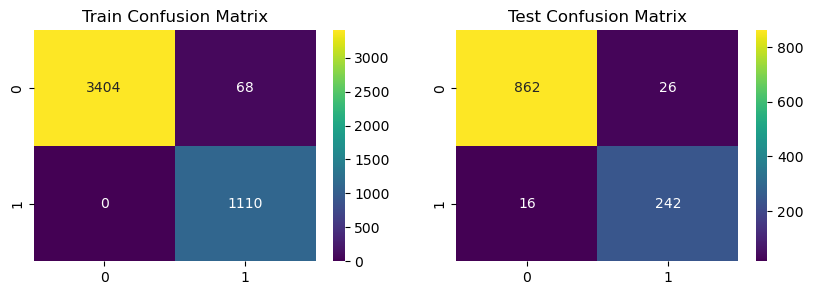

In [60]:
# let's have a look at the classification report and confution matrix
score_show('SVC with Vectorizer and Balance',SVC_gridSearch_sam_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 862 times and spam 242 times. However, the model made a false positive error 26 times and a false negative error 16 times.

### Step#6.7: SGDClassifier

In [61]:
# training the model using SGD Classifier with Grid Search
SGD_classifier = SGDClassifier(class_weight='balanced')
SGD_classifier.fit(X_train, y_train)

params_SGD= {'loss': ['hinge', 'log_loss', 'log'],
             'penalty': ['l2', 'l1', 'elasticnet'],             
             'verbose': ['bool', False], 
             'alpha': [1,50,100] 
             }

SGD_gridSearch_classifier = GridSearchCV(SGD_classifier, params_SGD, cv = 6, n_jobs = -1, scoring = 'accuracy')
SGD_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=SGDClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'alpha': [1, 50, 100],
                         'loss': ['hinge', 'log_loss', 'log'],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'verbose': ['bool', False]},
             scoring='accuracy')

In [62]:
# selection of the best parameters
SGD_gridSearch_classifier.best_params_

{'alpha': 50, 'loss': 'log', 'penalty': 'l2', 'verbose': False}

Train: 
accuracy 0.9683544303797469
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.97      0.98      0.98      0.97      0.94      3472
          1       0.90      0.98      0.97      0.94      0.97      0.95      1110

avg / total       0.97      0.97      0.98      0.97      0.97      0.94      4582

----------------------------------------------
Test: 
accuracy 0.9650959860383944
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.96      0.97      0.98      0.97      0.93       888
          1       0.89      0.97      0.96      0.93      0.97      0.93       258

avg / total       0.97      0.97      0.97      0.97      0.97      0.93      1146



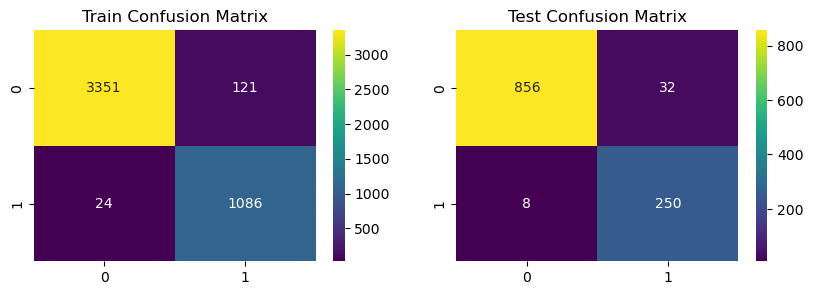

In [63]:
# let's have a look at the classification report and confution matrix
score_show('SGDClassifier with Vectorizer',SGD_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 856 times and spam 250 times. However, the model made a false positive error 32 times and a false negative error 8 times.

 #### Combination of over- and under-sampling methode to Balance Dataset

In [64]:
# training the model using Pipeline with Grid Search
SGD_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('SGD_clf', SGDClassifier())
                     ])
params_SGD= {'SGD_clf__loss': ['hinge', 'log_loss', 'log'], 
             'SGD_clf__penalty': ['l2', 'l1', 'elasticnet'],            
             'SGD_clf__verbose': ['bool', False], 
             'SGD_clf__alpha': [1,50,100] 
             }
SGD_gridSearch_sam_classifier = GridSearchCV(SGD_pipe, params_SGD, cv = 6, n_jobs = -1, scoring = 'accuracy')
SGD_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('SGD_clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'SGD_clf__alpha': [1, 50, 100],
                         'SGD_clf__loss': ['hinge', 'log_loss', 'log'],
                         'SGD_clf__penalty': ['l2', 'l1', 'elasticnet'],
                         'SGD_clf__verbose': ['bool', False]},
             scoring='accuracy')

In [65]:
# selection of the best parameters
SGD_gridSearch_sam_classifier.best_params_

{'SGD_clf__alpha': 1,
 'SGD_clf__loss': 'hinge',
 'SGD_clf__penalty': 'l2',
 'SGD_clf__verbose': False}

Train: 
accuracy 0.9877782627673505
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.97      0.99      0.98      0.96      3472
          1       0.98      0.97      0.99      0.97      0.98      0.96      1110

avg / total       0.99      0.99      0.97      0.99      0.98      0.96      4582

----------------------------------------------
Test: 
accuracy 0.9808027923211169
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.96      0.99      0.97      0.95       888
          1       0.96      0.96      0.99      0.96      0.97      0.94       258

avg / total       0.98      0.98      0.96      0.98      0.97      0.95      1146



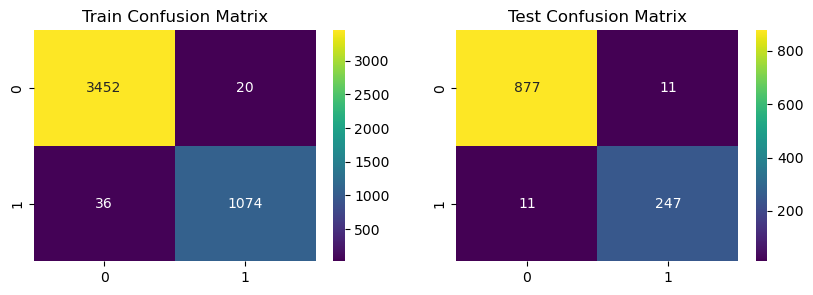

In [66]:
# let's have a look at the classification report and confution matrix
score_show('SGDClassifier with Vectorizer and Balance',SGD_gridSearch_sam_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 877 times and spam 247 times. However, the model made a false positive error 11 times and a false negative error 11 times.

### Step#6.8: XGBClassifier

In [67]:
# training the model using XGB Classifier with Grid Search
XGB_classifier = XGBClassifier()
XGB_classifier.fit(X_train, y_train)

params_XGB= {'n_estimators': [100,200,50], 
             'max_depth': [10,20,12],            
             #'objective': ['binary:logistic']  #corresponding learning objective
             }

XGB_gridSearch_classifier = GridSearchCV(XGB_classifier, params_XGB, cv = 6, n_jobs = -1, scoring = 'accuracy')
XGB_gridSearch_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1, ...),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 12],
                         'n_estimators': [100, 200, 50]},
             scoring='accuracy')

In [68]:
# selection of the best parameters
XGB_gridSearch_classifier.best_params_

{'max_depth': 12, 'n_estimators': 50}

Train: 
accuracy 0.9991270187690965
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      3472
          1       1.00      1.00      1.00      1.00      1.00      1.00      1110

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      4582

----------------------------------------------
Test: 
accuracy 0.9869109947643979
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.97      0.99      0.98      0.97       888
          1       0.97      0.97      0.99      0.97      0.98      0.96       258

avg / total       0.99      0.99      0.98      0.99      0.98      0.97      1146



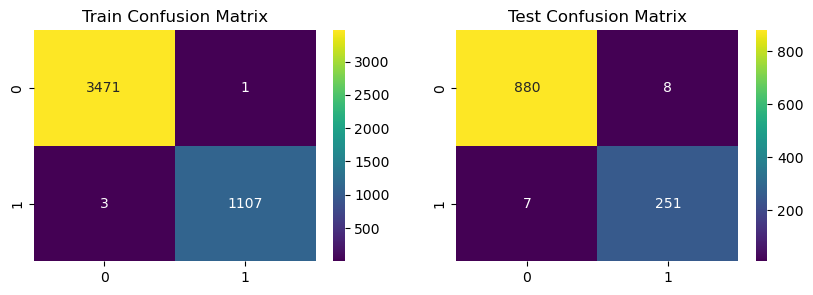

In [69]:
# let's have a look at the classification report and confution matrix
score_show('XGBClassifier with Vectorizer',XGB_gridSearch_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 880 times and spam 251 times. However, the model made a false positive error 8 times and a false negative error 7 times.

 #### Combination of over- and under-sampling methode to Balance Dataset

In [70]:
# training the model using Pipeline with Grid Search
XGB_pipe=imbPipeline([
                     ('sampling', SMOTETomek(sampling_strategy=0.5)),
                     ('XGB_clf', XGBClassifier())
                     ])
params_XGB= {'XGB_clf__n_estimators': [100,200,50], 
             'XGB_clf__max_depth': [10,20,12],            
             #'XGB_clf__objective': ['binary:logistic']  #corresponding learning objective
             }
XGB_gridSearch_sam_classifier = GridSearchCV(XGB_pipe, params_XGB, cv = 6, n_jobs = -1, scoring = 'accuracy')
XGB_gridSearch_sam_classifier.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('sampling',
                                        SMOTETomek(sampling_strategy=0.5)),
                                       ('XGB_clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                                      importance_typ...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None,
                                                      reg_alpha=None,
                                                      reg_lambda=None, ...))]),
             n_jobs=-1,
             param_grid={'XGB_clf__max_depth': [10, 20, 12],
                         'XGB_clf__n_estimators': [100, 200, 50]},
             scoring='accuracy')

In [71]:
# selection of the best parameters
XGB_gridSearch_sam_classifier.best_params_

{'XGB_clf__max_depth': 12, 'XGB_clf__n_estimators': 100}

Train: 
accuracy 0.9997817546922741
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      3472
          1       1.00      1.00      1.00      1.00      1.00      1.00      1110

avg / total       1.00      1.00      1.00      1.00      1.00      1.00      4582

----------------------------------------------
Test: 
accuracy 0.9842931937172775
                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      0.97      0.99      0.98      0.96       888
          1       0.97      0.97      0.99      0.97      0.98      0.95       258

avg / total       0.98      0.98      0.97      0.98      0.98      0.96      1146



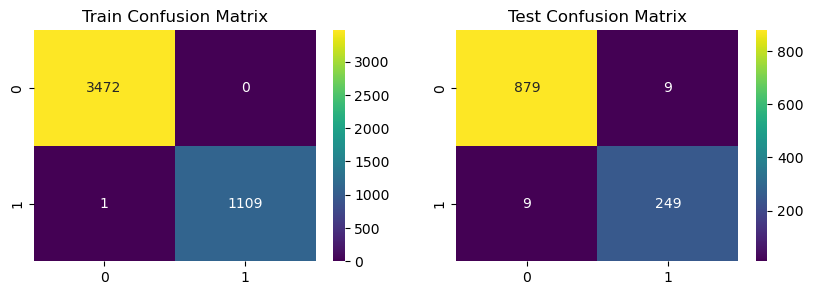

In [72]:
# let's have a look at the classification report and confution matrix
score_show('XGBClassifier with Vectorizer and Balance',XGB_gridSearch_sam_classifier, X_train, X_test, y_train, y_test)

On the test dataset, the model correctly predicted not spam 879 times and spam 249 times. However, the model made a false positive error 9 times and a false negative error 9 times.

In [73]:
# let's look at the results
show_results(results)

,modelName,accuracy_test,rocauc_test,precision_test,recall_test,f1_test
0,MultinominalNB with Vectorizer,0.990401,0.989682,0.969582,0.988372,0.978887
1,MultinominalNB with Vectorizer and Balance,0.989529,0.990493,0.962406,0.992248,0.977099
14,XGBClassifier with Vectorizer,0.986911,0.981930,0.969112,0.972868,0.970986
3,Logistic Regression with Vectorizer and Balanced,0.985166,0.983553,0.954717,0.980620,0.967495
15,XGBClassifier with Vectorizer and Balance,0.984293,0.977491,0.965116,0.965116,0.965116
2,Logistic Regression with Vectorizer,0.982548,0.984614,0.937500,0.988372,0.962264
13,SGDClassifier with Vectorizer and Balance,0.980803,0.972488,0.957364,0.957364,0.957364
10,SVC with Vectorizer,0.978185,0.966675,0.956863,0.945736,0.951267
12,SGDClassifier with Vectorizer,0.965096,0.966478,0.886525,0.968992,0.925926
11,SVC with Vectorizer and Balance,0.963351,0.954353,0.902985,0.937984,0.920152


##  Conclusion
In this project, we tried worked with NLP and built a model for predicting ham or spam.
* Before transforming a text column using sklearn's CountVectorizer, we eliminated the punctuation, then we split all the words  and made them all lower case. The we found each word root with lemmatizer. CountVectorizer was used for calculating an individual word count in the text.
* Analysis of the dataset showed that the dependent variable is imbalanced (not spam 76.12%, spam 23.88%).
* First, we trained the model using a pipeline with the original dependent variable. Then, we used a combination of oversampling and undersampling methods and balanced the target variable and trained model.
* A total of 16 models were trained (8 models without special balancing and 8 models with a сombination of over- and under-sampling method).
* The model MultinominalNB with Vectorizer showed the best result with 99% accuracy.
* The worst model is KNN with Vectorizer and Balance with an accuracy of 91%.